# Stokes drifters

In [1]:
# import needed packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import numpy as np

plt.style.use('../python_style_Meike.mplstyle')



In [5]:
# define needed functions
def Buoyancy_drifter(d, h, m, rho_water):
    V = 0.25 * np.pi * d * d * h
    rho_drifter = m / V
    B = rho_drifter/ rho_water
    return B

def stokes_relaxation_time(d, viscosity_water, B):
    return (1 + 2 * B) * d * d / (36 * viscosity_water)


def drag_length(d,B,Cd):
    return 2 * (1 + 2 * B) * d / (3 * Cd)
                    


In [3]:
d = 0.25 # m diameter outer ring
d_in = 0.2 # m (estimated) dimater inner ring, needed to caluclate volume
h = 0.041  # m (heigth drifter)
m = 0.905 # kg (mass drifter)
cd=0.45 # drag coefficient smooth sphere 
rho_water = 1027 # kg/m3 https://www.engineeringtoolbox.com/sea-water-properties-d_840.html (at 10 deg)
dynamic_viscosity_water = 1.41 * 10**(-3) # kg/(ms) https://www.engineeringtoolbox.com/sea-water-properties-d_840.html (at 10 deg)
kinematic_viscosity_water = dynamic_viscosity_water / rho_water
B = Buoyancy_drifter(d_in, h, m, rho_water)
tau = stokes_relaxation_time(d, kinematic_viscosity_water, B)
print(f'B = {B:.2f}')
print(f'tau = {tau:.2f}')
ld = drag_length(d_in,B,cd)
print(f'ld = {ld} m')


B = 0.68
tau = 2994.76
ld = 0.7017120538540955 m


In [ ]:
drag_length(B)

In [19]:
rho_PE = 961 # kg / m^3
tau_PE = stokes_relaxation_time(1/10, kinematic_viscosity_water, rho_PE / rho_water)
print(tau_PE)

580.9692671394798


In [ ]:
tau * 2 * (1 - B) / (2 * B + 1)  
tau/60 # minutes, quite similar to sargassum paper where they have 59 minutes)

199.6504541523039

In [4]:
# test displacement code

def displace_coordinates(lon, lat, d, B):
    """
    Function that displaces point(s) given by lon, lat over a distance d
    (in meters) in direction B (angle measured clockwise in radians from the
    north pole). The function returns the lon and lat coordinates of the
    displaced point(s).
    """
    Rearth = 6371 * 10**3 # radius earth in m
    lon_rad = lon * np.pi/180. 
    lat_rad = lat * np.pi/180. 
    lat_new = np.arcsin(np.sin(lat_rad) * np.cos(d / Rearth)+np.cos(lat_rad) * np.sin( d/ Rearth) * np.cos(B))
    lon_new = lon_rad + np.arcsin( np.sin(d / Rearth) * np.sin(B) / np.cos(lat_new))
    lat_new_angle = lat_new * 180/np.pi 
    lon_new_angle = lon_new * 180/np.pi 
    return lon_new_angle, lat_new_angle




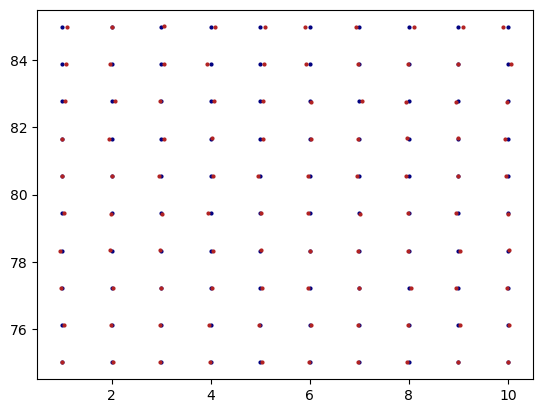

In [7]:
lon = np.linspace(1,10,10)
lat = np.linspace(75,85,10)
lon_particles, lat_particles = np.meshgrid(lon,lat)
lon_particles = lon_particles.flatten()
lat_particles = lat_particles.flatten()
nparticles=lat_particles.size
d = 1000 # displacement in meters
theta = np.random.rand(nparticles)*2*np.pi

lon_d, lat_d = displace_coordinates(lon_particles,lat_particles,d,theta)

fig,ax = plt.subplots()
ax.plot(lon_particles,lat_particles, 'o',color='navy',markersize=2)
ax.plot(lon_d,lat_d, 'o',color='firebrick',markersize=2)

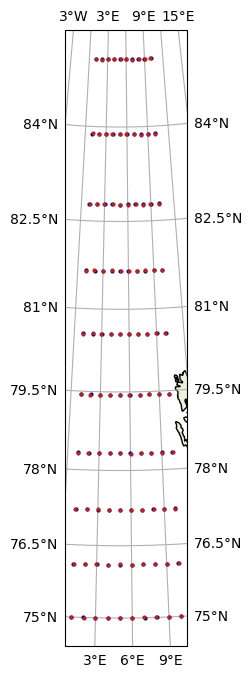

In [16]:

proj = ccrs.LambertConformal(central_longitude=5, central_latitude=80)

fig, ax = plt.subplots(facecolor="w", figsize=(20,8),
    subplot_kw=dict(projection=proj),
)

    
ax.plot(lon_particles,lat_particles, 'o',color='navy',markersize=2,zorder=20, transform=ccrs.PlateCarree())
ax.plot(lon_d,lat_d, 'o',color='firebrick',markersize=2,zorder=20, transform=ccrs.PlateCarree())

# ax.set_extent((1, 10, 75, 85))
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='k')
gl = ax.gridlines(
    draw_labels=True, rotate_labels=False,
    x_inline=False, y_inline=False,
)

Text(0, 0.5, 'difference in displacement [km]')

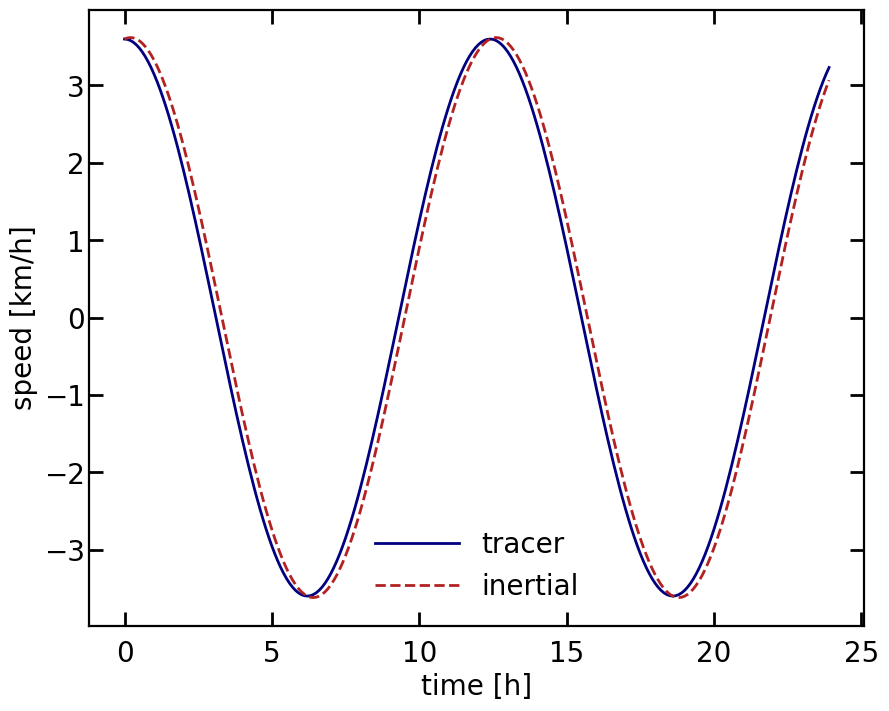

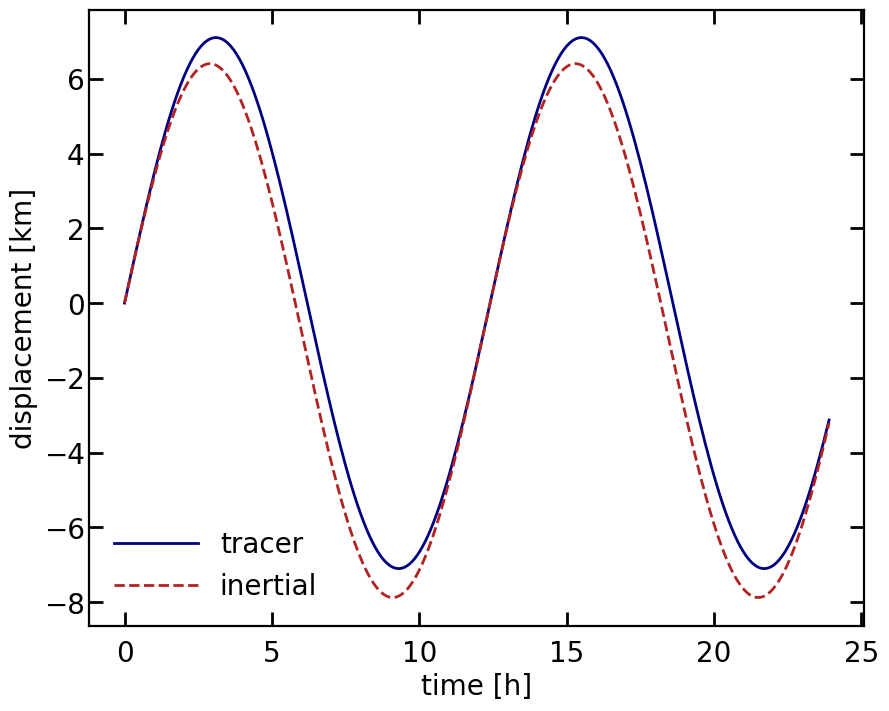

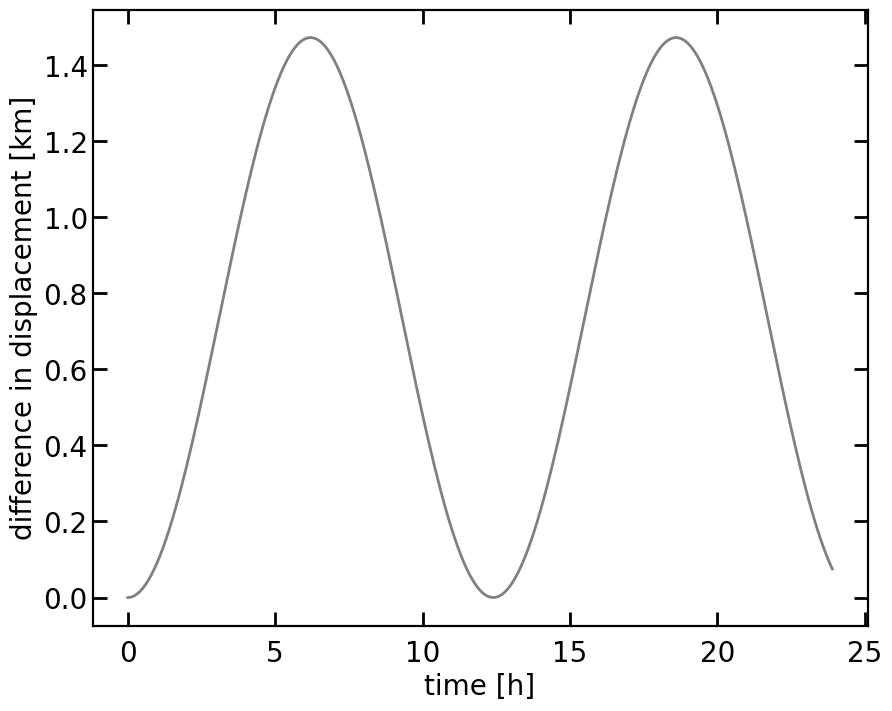

In [6]:
# theoretical tides plot
def Utide(A, f, t):
    return A * np.cos(f * t * 2 * np.pi)

def UMRtide(A,f,t,tau, B):
    factor = tau * 2 * (1 - B) / (2 * B + 1)
    return Utide(A, f, t) + factor * A * f * 2 * np.pi *  np.sin(f * t * 2 * np.pi)

def Xtidetracer(A, f, t):
    return A / (f * 2 * np.pi) * np.sin(f * t * 2 * np.pi)

def XtideMR(A,f,t, tau, B):
    factor = tau * 2 * (1 - B) / (2 * B + 1)  
    return Xtidetracer(A,f,t) + factor * Utide (A, f, t)


f = 1 / (12.4 ) # period is 12.4 h
A = 3.6 # km/h
tlist = np.arange(0,24,0.1)
fig,ax=plt.subplots()
ax.plot(tlist,Utide(A, f, tlist),color='navy')
ax.plot(tlist,UMRtide(A,f,tlist,tau/3600,B),'--',color='firebrick')
ax.set_xlabel('time [h]')
ax.set_ylabel('speed [km/h]')
ax.legend(['tracer','inertial'])

fig2,ax2=plt.subplots()
ax2.plot(tlist,Xtidetracer(A, f, tlist),color='navy')
ax2.plot(tlist,XtideMR(A,f,tlist,tau/3600,B) - XtideMR(A,f,0,tau/3600,B),'--',color='firebrick')
ax2.set_xlabel('time [h]')
ax2.set_ylabel('displacement [km]')
ax2.legend(['tracer','inertial'])

fig3,ax3=plt.subplots()
ax3.plot(tlist,Xtidetracer(A, f, tlist)-(XtideMR(A,f,tlist,tau/3600,B) - XtideMR(A,f,0,tau/3600,B)),color='grey')
ax3.set_xlabel('time [h]')
ax3.set_ylabel('difference in displacement [km]')